# Embedding a neuron model in a network model

This tutorial guides the user through how to use ISF to embed a neuron model in a dense connectome model, mapping synapses onto a neuron morphology based on empirical data. We provide a network modeling pipeline that has been described in detail in [Udvary et al. (2022)](https://doi.org/10.1016/j.celrep.2022.110677). 

To generate such synapse maps from scratch, the user must download the [barrel cortex model](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/JZPULN) from harvard Dataverse:

```shell
pixi run download_bc_model
```

To get started, adapt the desired output directory below:

In [1]:
from pathlib import Path
tutorial_output_dir = f"{Path.home()}/isf_tutorial_output"  # <-- Change this to your desired output directory

In [2]:
%matplotlib inline
import Interface as I
from getting_started import getting_started_dir
example_data_dir = I.os.path.join(getting_started_dir, 'example_data')
db = I.DataBase(tutorial_output_dir).create_sub_db("network_modeling")

[INFO] ISF: Current version: heads/data+0.gebc00ec75.dirty
[INFO] ISF: Current pid: 100207
[INFO] ISF: Loading mechanisms:
[ATTENTION] ISF: The source folder has uncommited changes!



[INFO] ISF: Loaded modules with __version__ attribute are:
IPython: 8.12.2, Interface: heads/data+0.gebc00ec75.dirty, PIL: 10.4.0, _brotli: 1.0.9, _csv: 1.0, _ctypes: 1.1.0, _curses: b'2.2', _decimal: 1.70, argparse: 1.1, backcall: 0.2.0, blosc: 1.11.1, bluepyopt: 1.9.126, brotli: 1.0.9, certifi: 2024.08.30, cffi: 1.17.0, charset_normalizer: 3.4.0, click: 7.1.2, cloudpickle: 3.1.0, colorama: 0.4.6, comm: 0.2.2, csv: 1.0, ctypes: 1.1.0, cycler: 0.12.1, cytoolz: 0.12.3, dash: 2.18.2, dask: 2.30.0, dateutil: 2.9.0, deap: 1.4, debugpy: 1.8.5, decimal: 1.70, decorator: 5.1.1, defusedxml: 0.7.1, distributed: 2.30.0, distutils: 3.8.20, django: 1.8.19, entrypoints: 0.4, executing: 2.1.0, fasteners: 0.17.3, flask: 1.1.4, fsspec: 2024.10.0, future: 1.0.0, greenlet: 3.1.1, idna: 3.10, ipaddress: 1.0, ipykernel: 6.2

## Registering the cell morphology in the desired reference frame

The first step to embedding a neuron model into a network model, is to align the reference frames of both.

From external resources (e.g. the NeuroMorph pipeline), you need a morphology `.hoc`-file. The coordinates in the hoc morphology file need to be anchored at the desired location.

As an example, we provide such file of a Layer-5 Pyramidal Tract Neuron (L5PT), whose coordinates are anchored in the C2 column of a rat barrel cortex (BC)

In [3]:
anatomy_dir = I.os.path.join(example_data_dir, 'anatomical_constraints')
I.os.listdir(anatomy_dir)

['89_L5_CDK20050712_nr6L5B_dend_PC_neuron_transform_registered_C2.hoc',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.swc',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc',
 'example_embedding_86_C2_center',
 'presynaptic_somata_soma_locations.csv',
 'NumberOfConnectedCells.csv']

In [4]:
path_to_hoc = I.os.path.join(
    anatomy_dir,
    '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc')
path_to_scaled_hoc = I.os.path.join(
    anatomy_dir,
    'anatomical_constraints', \
    '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc')

We copy these morphology files to our DataBase.

In [5]:
if not 'anatomical_constraints' in db.keys():
    db.create_managed_folder('anatomical_constraints')
    I.shutil.copy(path_to_hoc, db['anatomical_constraints'])
    I.shutil.copy(path_to_scaled_hoc, db['anatomical_constraints'])

## Calculating synapse positions on the neuron morphology

We use [`singlecell_input_mapper`](../singlecell_input_mapper/__init__.py) to create an anatomical model of how that cell is integrated in the brain are (here: the barrel cortex). For more information on how this is done, see [Egger et al. 2014](https://www.frontiersin.org/articles/10.3389/fnana.2014.00129/full). This module creates an anatomical reconstruction of axo-dendritic connections depending on the spatial distribution of cells, bouton density, and anatomical constraints of post-synaptic targets of the postsynaptic cell, such as morphology and synapse density. To do so, it needs the following input:
1. The neuron morphology (the `.hoc` file that we already copied over)
2. Density of total Post-Synaptic Target sites (PST) across the dendritic tree of the postynaptic cell (used for normalization)
3. Anatomical constraints of PSTs: the amount of synapses per length unit and area unit, depending on pre- and post-synaptic celltype, and the location along the dendritic tree of the postsynaptic cell. These are normalized using the previously mentioned PST densities.
4. Bouton densities across the entire brain area of interest.
5. Spatial distribution of cells, depending on their type.

Under the hood, multiple anatomical realizations will be computed, all of which consistent with the input data. 
From this distribution of anatomical realizations, the one that is closest to the average is chosen, which can be refered to as a "representative realization". The result is saved in the same folder as the hoc morphology. This takes about 4 hrs to compute, but you can continue with a precomputed result.

To compute it yourself, run the cell below. To copy a precomputed result, you can skip to the next code cell

### Computing it yourself

Here, we only use $2$ samples. 
This is generally not enough to get a sufficiently large distribution to draw a representative sample from. In our experience, $50$ samples is about enough to get a convergent distribution of synapse embeddings.

A sample size of $2$ is however sufficient for the sake of this tutorial.

In [ ]:
celltype = 'L5tt'  # Layer 5 thick-tufted
path = db['anatomical_constraints'].join('86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc')
I.map_singlecell_inputs(
    cellName=path, 
    cellTypeName=celltype,
    nrOfSamples=2  # <--- Increase this number to get more samples. 50 is sufficient for convergence, but 2 is faster
)

# Adapt the path if you have generated a new anatomical model
path_to_anatomical_model = db['anatomical_constraints'].join('example_embedding_86_C2_center')

### Copying a pre-computed result

In [7]:
# Pre-computed result: --------------------
from distutils.dir_util import copy_tree
path_to_anatomical_model = I.os.path.join(anatomy_dir, "example_embedding_86_C2_center")
silent = copy_tree(path_to_anatomical_model, db['anatomical_constraints'])

### Parallelizing the generation of anatomical models

We can use a dask `Client` to create our `.syn` and `.con` files for one morphology per process:

In [ ]:
client = I.get_client(timeout=10)
client

In [24]:
morphology_paths = [db['anatomical_constraints'].join(f) for f in db['anatomical_constraints'].listdir() if f.endswith('.hoc')]
morphology_paths

['/home/bgmeulem/isf_tutorial_output/network_modeling/db/anatomical_constraints/86_C2_center.hoc',
 '/home/bgmeulem/isf_tutorial_output/network_modeling/db/anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc']

This takes as long as creating an anatomical realization for a single cell, but thanks to parallellization, not much longer than that. At least, until the amount of cells exceed the amount of available threads.

In [ ]:
delayed_map_singlecell_inputs = I.dask.delayed(I.map_singlecell_inputs)  # make the single cell mapper a delayed function
delayeds = [delayed_map_singlecell_inputs(p, 'L5tt') for p in morphology_paths] # call it with the morphologies
delayeds = I.dask.delayed(delayeds) # bundle everything in one delayed object
futures = client.compute(delayeds)  # compute the result

You can restart the client to interrupt this computation if don't want to compute this right now

In [ ]:
client.restart()

## Inspecting the network model

### Visualization

Let's start by visualizing the locations of the somata to get a sense of our network model.

In [26]:
landmarks = []
cell_types = []

somata = I.pd.read_csv(
    I.os.path.join(anatomy_dir, "presynaptic_somata_soma_locations.csv"), 
    skiprows=[0,1,2,3],
    header=None,
    delimiter="\t",
    names=['Type', 'cell ID', 'x', 'y', 'z']
    )
somata[['cell_type', 'column']] = somata['Type'].str.split('_', n=1, expand=True)
somata

,Type,cell ID,x,y,z,cell_type,column
0,L45Peak_D1,0,-626.213,20.344,-58.270,L45Peak,D1
1,L45Peak_D1,1,-320.834,13.905,-248.013,L45Peak,D1
2,L45Peak_D1,2,-471.762,100.233,-114.434,L45Peak,D1
3,L45Peak_D1,3,-423.770,94.010,-156.002,L45Peak,D1
4,L45Peak_D1,4,-294.765,145.499,-241.157,L45Peak,D1
...,...,...,...,...,...,...,...
19699,L34_D3,292,485.718,83.024,122.828,L34,D3
19700,L34_D3,293,483.525,-213.608,190.240,L34,D3
19701,L34_D3,294,586.649,-160.437,98.395,L34,D3
19702,L34_D3,295,275.697,189.550,319.151,L34,D3


In [27]:
I.plt.style.use('ggplot')

#### Plot per cell type

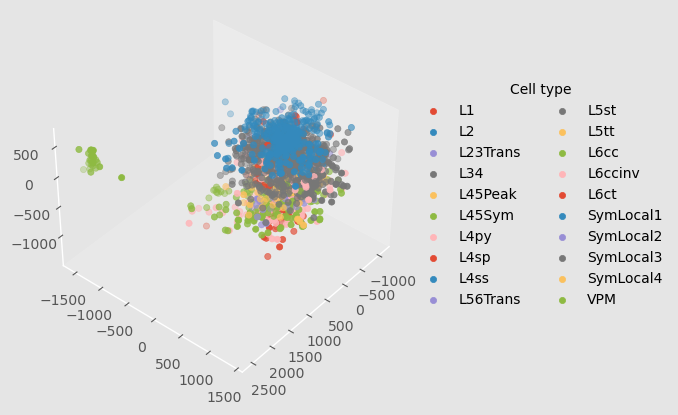

In [28]:
fig = I.plt.figure()
ax = fig.add_subplot(projection='3d')
fig.patch.set_facecolor(ax.get_facecolor())
ax.view_init(azim=40, elev=40)
ax.grid(False)

for cell_type, pts in somata.sample(2000).groupby("cell_type"):
    x, y, z = pts[["x", "y", "z"]].values.T
    ax.scatter(
        x, y, z,
        label=cell_type)

ax.legend(
    bbox_to_anchor=(1, 0.5), 
    loc='center left', 
    frameon=False, 
    ncol=2,
    title="Cell type")
I.plt.show()

#### Plot per column

Since the barrel cortex is well-organized into recognizable columns, we can colorize the cells based on which column they belong to:

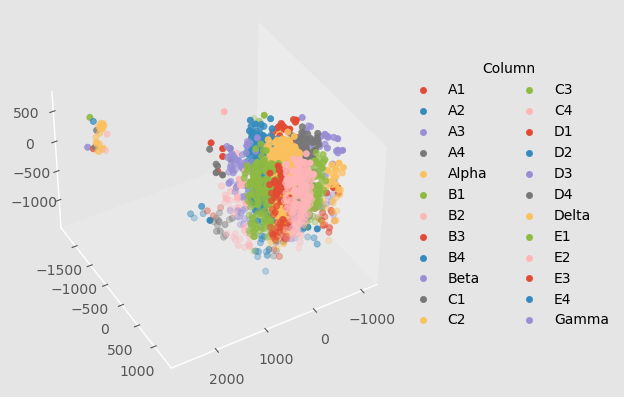

In [29]:
fig = I.plt.figure()
ax = fig.add_subplot(projection='3d')
fig.patch.set_facecolor(ax.get_facecolor())
ax.view_init(azim=60, elev=40)
ax.grid(False)

for column, pts in somata.sample(2000).groupby("column"):
    x, y, z = pts[["x", "y", "z"]].values.T
    ax.scatter(
        x, y, z, 
        label=column)

ax.legend(
    bbox_to_anchor=(1, 0.5), 
    loc='center left', 
    frameon=False, 
    ncol=2,
    title="Column")
I.plt.show()

### Inspecting the output format

In the directory generated by the singlecell_input_mapper, there are the following files:

In [30]:
db['anatomical_constraints'].listdir()

['Loader.json',
 'metadata.json',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc',
 '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc',
 'example_embedding_86_C2_center.con',
 'example_embedding_86_C2_center.syn']

The most important files for making single-cell simulations are the `.con` file and the `.syn` file. These files are the relevant output of the [`map_singlecell_inputs`](../../../singlecell_input_mapper/map_singlecell_inputs.py) pipeline.

The `.con` file maps presynaptic cells to a synapse. Not just a celltype, but all individual cells with a specific `cell ID` are mapped to an individual synapse with `synase ID`.

In [31]:
con_file = db['anatomical_constraints'].get_file('.con')
con_file_path = db['anatomical_constraints'].join(con_file)
con_file_path

'/home/bgmeulem/isf_tutorial_output/network_modeling/db/anatomical_constraints/example_embedding_86_C2_center.con'

In [32]:
with open(con_file_path) as f:
    print(f.read()[:300])

# Anatomical connectivity realization file; only valid with synapse realization:
# 86_C2_center.syn
# Type - cell ID - synapse ID

L6cc_A3	0	0
L6cc_A3	1	1
L6cc_A3	2	2
L6cc_A3	3	3
L6cc_A3	4	4
L6cc_A3	4	5
L6cc_A3	5	6


The `.syn` file specifies the exact position of each synapse on the hoc morphology:

In [33]:
syn_file_path = db['anatomical_constraints'].join(db['anatomical_constraints'].get_file('.syn'))
with open(syn_file_path) as f:
    print(f.read()[:300])

# Synapse distribution file
# corresponding to cell: 86_C2_center
# Type - section - section.x

VPM_E1	112	0.138046479525
VPM_E1	130	0.305058053119
VPM_E1	130	0.190509288017
VPM_E1	9	0.368760777084
VPM_E1	110	0.0
VPM_E1	11	0.120662910562


Here, section referes to the ID of the section in the cell object. x specifies, where along that section the synapse is placed. If x is 0, this is the beginning of the section, if x is one, this is the end of the section.

## Compatibility with other dense connectome models.

ISF is not limited to this particular way of generating synapse locations. As long as a `.syn` and `.con` file can be distilled, any dense connectome model is compatible with ISF. All further workflows in ISF simply rely on these `.syn` and `.con` files, not on the input data that was necessary to generate these. in other words, the barrel cortex model as downloaded in the beginning of this tutorial is simply one example of a network model. Many other dense connectome models may be used.

## Recap

This tutorial provided a full pipeline on how to generate synapse locations for a given neuron morphology (i.e. an "anatomical network embedding"), and how to parallellize these for multiple morphologies.

In order to assign activity to these synapse realizations, consult the [the next tutorial](./2.2%20Network%20activity.ipynb).